# 多层感知机
- 仿射变换是一个线性很强的假设
- 线性意味着单调假设：任何特征的增大都会导致模型输出的增大（如果对应的权重为正）， 或者导致模型输出的减小（如果对应的权重为负）。
- 如果对于图片进行分类或者是一些违反单调性的例子里，线性的模型注定会失败
- 通过在网络中加入一个或者多个隐藏层来克服线性模型的限制，能够处理更加普遍的函数关系，将全连接层堆叠在一起。
- 加入激活函数（非线性的）， 一般来说，有了激活函数，就不可能再将我们的多层感知机退化成线性模型

In [2]:
%matplotlib inline

import torch as t
import torch.nn as nn
import sys
sys.path.append("../")
from pltutils import *
import numpy as np

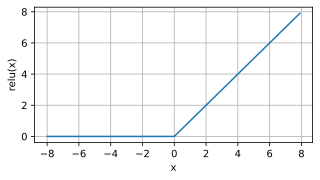

In [3]:
x=t.arange(-8.,8.,0.1,requires_grad=True)
y=t.relu(x)
plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

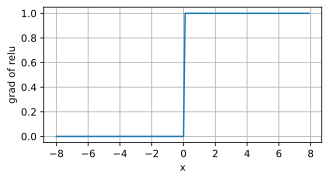

In [4]:
y.backward(t.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

- 使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。 这使得优化表现的更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题
- pReLU，leaky ReLu之类的玩意，都是ReLU的变体

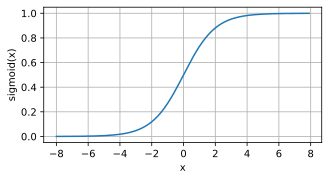

In [5]:
y=t.sigmoid(x)
plot(x.detach(),y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

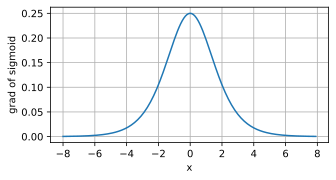

In [6]:
x.grad.zero_()
y.backward(t.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

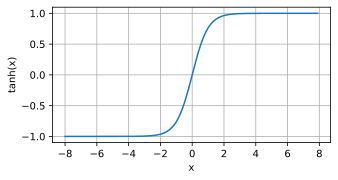

In [7]:
y=t.tanh(x)
plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

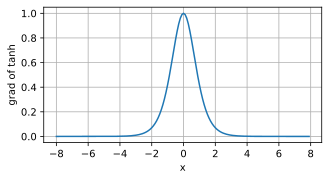

In [8]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# 开始模型定义！
工程步骤
1. 数据集
2. 模型
3. 优化器
4. 训练
5. 预测

In [9]:

import torch.nn as nn
from torch import Tensor
train_iter,test_iter=load_data_fashion_mnist(256,n_threads=0,data_root="./dataset")

In [10]:
n_features=784
n_outputs=10
n_hiddens=256
DEVICE = t.device("cuda:0" if t.cuda.is_available() else "cpu")
W1=nn.Parameter(t.randn(n_features,n_hiddens,requires_grad=True,device=DEVICE)*0.01)
b1 = nn.Parameter(t.zeros(n_hiddens, requires_grad=True, device=DEVICE))
W2 = nn.Parameter(t.randn(n_hiddens, n_outputs,
                  requires_grad=True, device=DEVICE)*0.01)
b2 = nn.Parameter(t.zeros(n_outputs, requires_grad=True, device=DEVICE))
params=[W1,b1,W2,b2]

# activation
def relu(x:Tensor):
    a=t.zeros_like(x)
    return t.max(x,a)

def net(x:Tensor):
    x=x.reshape((-1,n_features))
    H=relu(x@W1+b1)
    return (H@W2+b2)

loss_func=nn.CrossEntropyLoss()
optimizer=t.optim.SGD(params,lr=0.1)



def accuracy(y_hat: Tensor, y: Tensor) -> Tensor:
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train(net, train_iter: data.DataLoader, loss, updater, n_epochs=10):
    if isinstance(net, t.nn.Module):
        net.train()
    for i in range(n_epochs):
        for x, y in train_iter:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            y_hat = net(x)
            l = loss(y_hat, y)

            if isinstance(updater, t.optim.Optimizer):
                updater.zero_grad()
                l.sum().backward()
                updater.step()
            else:
                l.sum().backward()
                updater(x.shape[0])
            print("ep:{},accuracy:{:.4f},loss:{:.4f}".format(
                i, accuracy(y_hat, y)/y.shape[0], l.mean().item()))




In [11]:
train(net,train_iter,loss_func,optimizer,10)

ep:0,accuracy:0.0664,loss:2.3005
ep:0,accuracy:0.2109,loss:2.2938
ep:0,accuracy:0.1602,loss:2.2891
ep:0,accuracy:0.2539,loss:2.2792
ep:0,accuracy:0.2617,loss:2.2715
ep:0,accuracy:0.1875,loss:2.2677
ep:0,accuracy:0.1953,loss:2.2590
ep:0,accuracy:0.1875,loss:2.2528
ep:0,accuracy:0.2305,loss:2.2404
ep:0,accuracy:0.2227,loss:2.2238
ep:0,accuracy:0.1445,loss:2.2166
ep:0,accuracy:0.2070,loss:2.1837
ep:0,accuracy:0.1719,loss:2.1750
ep:0,accuracy:0.1641,loss:2.1854
ep:0,accuracy:0.2734,loss:2.1491
ep:0,accuracy:0.2422,loss:2.1293
ep:0,accuracy:0.2188,loss:2.1207
ep:0,accuracy:0.2852,loss:2.0788
ep:0,accuracy:0.3125,loss:2.0654
ep:0,accuracy:0.4141,loss:2.0444
ep:0,accuracy:0.5039,loss:2.0025
ep:0,accuracy:0.5000,loss:1.9626
ep:0,accuracy:0.4883,loss:1.9268
ep:0,accuracy:0.3750,loss:1.9166
ep:0,accuracy:0.4961,loss:1.8627
ep:0,accuracy:0.4180,loss:1.8748
ep:0,accuracy:0.4883,loss:1.8184
ep:0,accuracy:0.4844,loss:1.7923
ep:0,accuracy:0.5195,loss:1.7338
ep:0,accuracy:0.5234,loss:1.6440
ep:0,accur

# 使用t.nn来搭建网络

In [16]:
net_torch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,10)
)
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net_torch.apply(init_weights)
DEVICE = t.device("cuda:0" if t.cuda.is_available() else "cpu")
net_torch=net_torch.to(DEVICE)
lr, num_epochs =  0.1, 10
loss=nn.CrossEntropyLoss()
optimizer=t.optim.SGD(net_torch.parameters(),lr=lr)
train_iter, test_iter = load_data_fashion_mnist(
    256, n_threads=0, data_root="./dataset")
train(net_torch,train_iter,loss,optimizer,num_epochs)


ep:0,accuracy:0.1016,loss:2.3098
ep:0,accuracy:0.0977,loss:2.2984
ep:0,accuracy:0.1602,loss:2.2926
ep:0,accuracy:0.1133,loss:2.2949
ep:0,accuracy:0.1250,loss:2.2760
ep:0,accuracy:0.2188,loss:2.2651
ep:0,accuracy:0.1797,loss:2.2633
ep:0,accuracy:0.2266,loss:2.2490
ep:0,accuracy:0.2422,loss:2.2375
ep:0,accuracy:0.1797,loss:2.2350
ep:0,accuracy:0.2148,loss:2.2205
ep:0,accuracy:0.2734,loss:2.2124
ep:0,accuracy:0.2969,loss:2.1944
ep:0,accuracy:0.2969,loss:2.1821
ep:0,accuracy:0.3125,loss:2.1625
ep:0,accuracy:0.3086,loss:2.1247
ep:0,accuracy:0.2695,loss:2.1124
ep:0,accuracy:0.2969,loss:2.0993
ep:0,accuracy:0.3086,loss:2.0622
ep:0,accuracy:0.2852,loss:2.0386
ep:0,accuracy:0.3477,loss:2.0000
ep:0,accuracy:0.3672,loss:1.9951
ep:0,accuracy:0.3906,loss:1.9801
ep:0,accuracy:0.5117,loss:1.9105
ep:0,accuracy:0.3438,loss:1.9276
ep:0,accuracy:0.4766,loss:1.8439
ep:0,accuracy:0.4453,loss:1.8263
ep:0,accuracy:0.5078,loss:1.8115
ep:0,accuracy:0.5508,loss:1.7720
ep:0,accuracy:0.5742,loss:1.7295
ep:0,accur